In [1]:
import gensim.models.keyedvectors as word2vec 
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report



import os

Using TensorFlow backend.


In [2]:
# get the current working directory
data_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Datasets'))+'/'

# Although the dataset says csv, it is tab delimited. In addition to this, they have severe codels problems. 
# So best to parse throught codes first. 
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 2: invalid start byte

#open for reading with "universal" type set

import codecs

doc_d_t = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_target'+'.csv','rU','UTF-8') 
EUADR_drug_target = pd.read_csv(doc_d_t, sep='\t', na_filter = False)
EUADR_drug_target['CLASS'] = 'drug_gene'

doc_t_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_target_disease'+'.csv','rU','UTF-8',errors='ignore') 
EUADR_target_disease = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
EUADR_target_disease['CLASS'] = 'gene_disease'
       
doc_d_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_disease'+'.csv','rU','UTF-8')                       
EUADR_drug_disease = pd.read_csv(doc_d_d, sep='\t', na_filter = False)
EUADR_drug_disease['CLASS'] = 'drug_disease'


EUADR_temp = EUADR_drug_target.append(EUADR_target_disease).append(EUADR_drug_disease)

EUADR_temp_1 = EUADR_temp[EUADR_temp['ASSOCIATION_TYPE'] == 'PA']
EUADR_temp_2 = EUADR_temp[EUADR_temp['ASSOCIATION_TYPE'] == 'NA']
EUADR_temp = EUADR_temp_1.append(EUADR_temp_2)

In [3]:
# Get GAD datasset

doc_t_d = codecs.open(data_path+'GAD_Corpus_IBIgroup/'+'GAD_Y_N'+'.csv','rU','UTF-8',errors='ignore') 
GAD_target_disease_Y_N = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
GAD_target_disease_Y_N['CLASS'] = 'gene_disease'

doc_t_d = codecs.open(data_path+'GAD_Corpus_IBIgroup/'+'GAD_F'+'.csv','rU','UTF-8',errors='ignore') 
GAD_target_disease_F = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
GAD_target_disease_F['CLASS'] = 'gene_disease'

GAD_temp = GAD_target_disease_Y_N


PA    2366
NA     994
dtype: int64


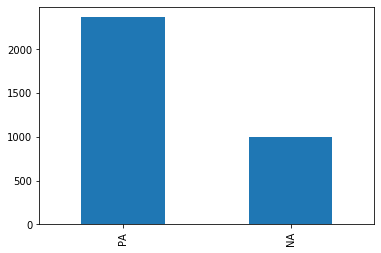

In [4]:
# get sentences and their associations

sentences = EUADR_temp['SENTENCE'].append(GAD_temp['GAD_CONCLUSION'])
labels = EUADR_temp['ASSOCIATION_TYPE'].append(GAD_temp['GAD_ASSOC'].apply(lambda x: x.replace('Y', 'PA').replace('N', 'NA').replace('F', 'FA')))

labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())



In [5]:
from sklearn import preprocessing
from keras.utils import np_utils

le = preprocessing.LabelEncoder()

le.fit(labels)
le.classes_
# le.inverse_transform()

y = le.transform(labels)
dummy_y = np_utils.to_categorical(y)


In [6]:
def format_sentences(a_list_of_sentences):
    
    tkr = RegexpTokenizer('[a-zA-Z@]+')
    sentences_split = []

    for i, line in enumerate(a_list_of_sentences):
        #print(line)
        sent = str(line).lower().split()
        sent = tkr.tokenize(str(sent))
        sentences_split.append(sent)
        
    return sentences_split

sentences_split = format_sentences(sentences)
print(sentences_split[1])



['inactivation', 'of', 'egfr', 'kinase', 'by', 'gefitinib', 'was', 'analyzed', 'by', 'western', 'blot', 'analysis', 'and', 'immunofluorescence']


In [7]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-w2v.bin', binary=True, limit=1000000)

#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_split)
X = tokenizer.texts_to_sequences(sentences_split)

#lenght of sentence to consider
maxlenth = 10
#add padding
X = pad_sequences(X, maxlen=maxlenth)
print(X.shape)

#create a embedding layer using PMC vectors (100000 words)
embedding_layer = Embedding(input_dim=w2vModel.wv.vectors.shape[0], output_dim=w2vModel.wv.vectors.shape[1], weights=[w2vModel.wv.vectors], 
                            input_length=X.shape[1])



/home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
W0723 12:38:33.681522 139955076097792 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



(3360, 10)


In [11]:
#create model

lstm_out = 80

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=lstm_out))
# model.add(Dense(1, activation='softmax'))
model.add(Dense(2, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 200)           200000000 
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                89920     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 162       
Total params: 200,090,082
Trainable params: 200,090,082
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
from sklearn.model_selection import train_test_split

#split dataset
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.1, random_state = 24, stratify=y)
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size= 0.1, random_state = 24, stratify=y)

#fit model
batch_size = 1024
model.fit(X_train, Y_train, epochs=25, verbose=1, batch_size=batch_size)

#analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

Epoch 1/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0685 - acc: 0.9762
Epoch 2/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0624 - acc: 0.9729
Epoch 3/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0578 - acc: 0.9765
Epoch 4/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0506 - acc: 0.9805
Epoch 5/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0500 - acc: 0.9792
Epoch 6/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0450 - acc: 0.9808
Epoch 7/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0412 - acc: 0.9821
Epoch 8/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0397 - acc: 0.9821
Epoch 9/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0400 - acc: 0.9798
Epoch 10/25
3024/3024 [==============================] - 6s 2ms/step - loss: 0.0366 - acc: 0.9812
Epoch 11/25
3024/3024 [======

In [25]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')  
# f1_score(Y_test, y_pred, average='micro')  

# f1_score(Y_test, y_pred.round(), average='macro')



0.8697869331006051

In [24]:
#Let us test some  samples
# test_samples = ["The human T1663A GH1 gene polymorphism, which may confer lower levels of GH and IGF-I, appears to be associated with a decreased risk of colorectal cancer."]
# test_samples = ["Individuals who bear GSTT1 0/0 genotype or GSTT1 0/0-GSTM1 0/0 combined genotypes are more susceptible to leukemia, especially for male and younger carriers."]
test_samples = ["We found no evidence that mutation in GUCA1B,GNGT1,or RGS9 gene is a cause of retinitis pigmentosa."]
# test_samples = ['These results suggest that HLA class I antigens and TNF-alpha A-308G are not associated with susceptibility or resistance to the development of TDI-induced asthma.']
# test_samples = ['The results suggest that the studied dinucleotide repeat polymorphism of the ER alpha gene may contribute to specific components of personality.']

test_sample_split = format_sentences(test_samples)
test_ = tokenizer.texts_to_sequences(test_sample_split)
test_pad = pad_sequences(test_, maxlen=maxlenth)
#predict
# model.predict(x=test_pad)

dic = dict(zip(le.classes_, model.predict(x=test_pad).tolist()[0]))

dic

{'NA': 0.9999264478683472, 'PA': 7.356299465755001e-05}